# **Group 37: DSCI 100 - Physical Characteristics of Tennis Players Influencing their Likelihood of Winning Matches**

----------------------------------------------------------


## Research question: do tennis players' physical characteristics influence the likelihood of winning a game?


## Introduction
Our project aims to identify the likelihood of winning (or losing) tennis matches in the ATP tournament based on a player’s physical characteristics such as height and age. Our dataset is taken from [Jeff Sackmann’s tennis database on GitHub](https://github.com/JeffSackmann/tennis_atp) and compiles ATP tournament match data from 2020. The ATP Tour is a global top-level male tennis tour organised by the Association of Tennis Professionals (ATP). 

While our dataset contains 50 columns and almost 7000 rows, we are whittling this down to focus on exclusively physical characteristic data of players. We have also created a new binary variable, `win_lose`, which indicates the overall result of a tennis match. Our project will focus on a $K$-nearest neighbours classification analysis of our two classifier variables and our one predictor variable. We will try to predict the outcome of  a match based on players' age and height.



In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RCurl)
options(repr.matrix.max.rows = 6)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#reading the dataset into Jupyter
x <- getURL("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2020.csv")
match_data <- read.csv(text = x)
match_data #table 1.1

tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2020-8888,Atp Cup,Hard,24,A,20200106,300,104925,NA,,⋯,51,39,6,10,6,8,2,9055,1,9985
2020-8888,Atp Cup,Hard,24,A,20200106,299,105138,NA,,⋯,35,21,6,9,5,10,10,2335,34,1251
2020-8888,Atp Cup,Hard,24,A,20200106,298,104925,NA,,⋯,57,35,25,14,6,11,2,9055,5,5705
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2020-7485,Antwerp,Hard,32,A,20201019,128,126203,7,,⋯,37,30,5,9,3,5,28,1670,33,1402
2020-7485,Antwerp,Hard,32,A,20201019,129,144750,NA,Q,⋯,45,29,5,10,7,11,90,748,74,838
2020-7485,Antwerp,Hard,32,A,20201019,130,200005,NA,,⋯,32,26,7,9,2,4,38,1306,172,353


In [3]:
#Split match_data into two tables based on whether a player won or lost their match
#Add a variable indicating said win or loss
#Select for the variables of interest: height and age and match_result
#Rename height and age column names to remove redundancy and improve consistency
match_data_winner <- match_data |> 
                    mutate(match_result = "win") |>
                    select(winner_ht, winner_age, match_result) |>
                    rename(ht = winner_ht, age = winner_age)

match_data_loser <- match_data |> 
                    mutate(match_result = "lose") |>
                    select(loser_ht, loser_age, match_result) |>
                    rename(ht = loser_ht, age = loser_age)

#Recombine the two tables into one
match_data_tidy <- bind_rows(match_data_winner, match_data_loser)
match_data_tidy #table 1.2

ht,age,match_result
<int>,<dbl>,<chr>
188,32.6,win
183,31.7,win
188,32.6,win
⋮,⋮,⋮
211,23.1,lose
178,21.5,lose
180,26.6,lose


In [4]:
#Seperating the Data into training and test sets, with a training/testing split of 75/25% based on the match result
match_split <- initial_split(match_data_tidy, prop = 0.75, strata = match_result)
match_train <- training(match_split)
match_test <- testing(match_split)

In [5]:
#Check number of missing values in each column of the table ONLY USING TRAINING DATA
num_na <- match_train |> 
            summarize_all(~sum(is.na(.)))
num_na #table 1.3

ht,age,match_result
<int>,<int>,<int>
36,0,0


In [6]:
#remove NA tuples from datasets
match_train <- filter(match_train, !is.na(ht))
match_test <- filter(match_test, !is.na(ht))

**NOTE**: 
Of the 2934 tuples in our dataset, 36 of them have a NA value in one of the variables of interest. Thats only slightly more than 1% of the data, so the dataset is still suitable for analysis.

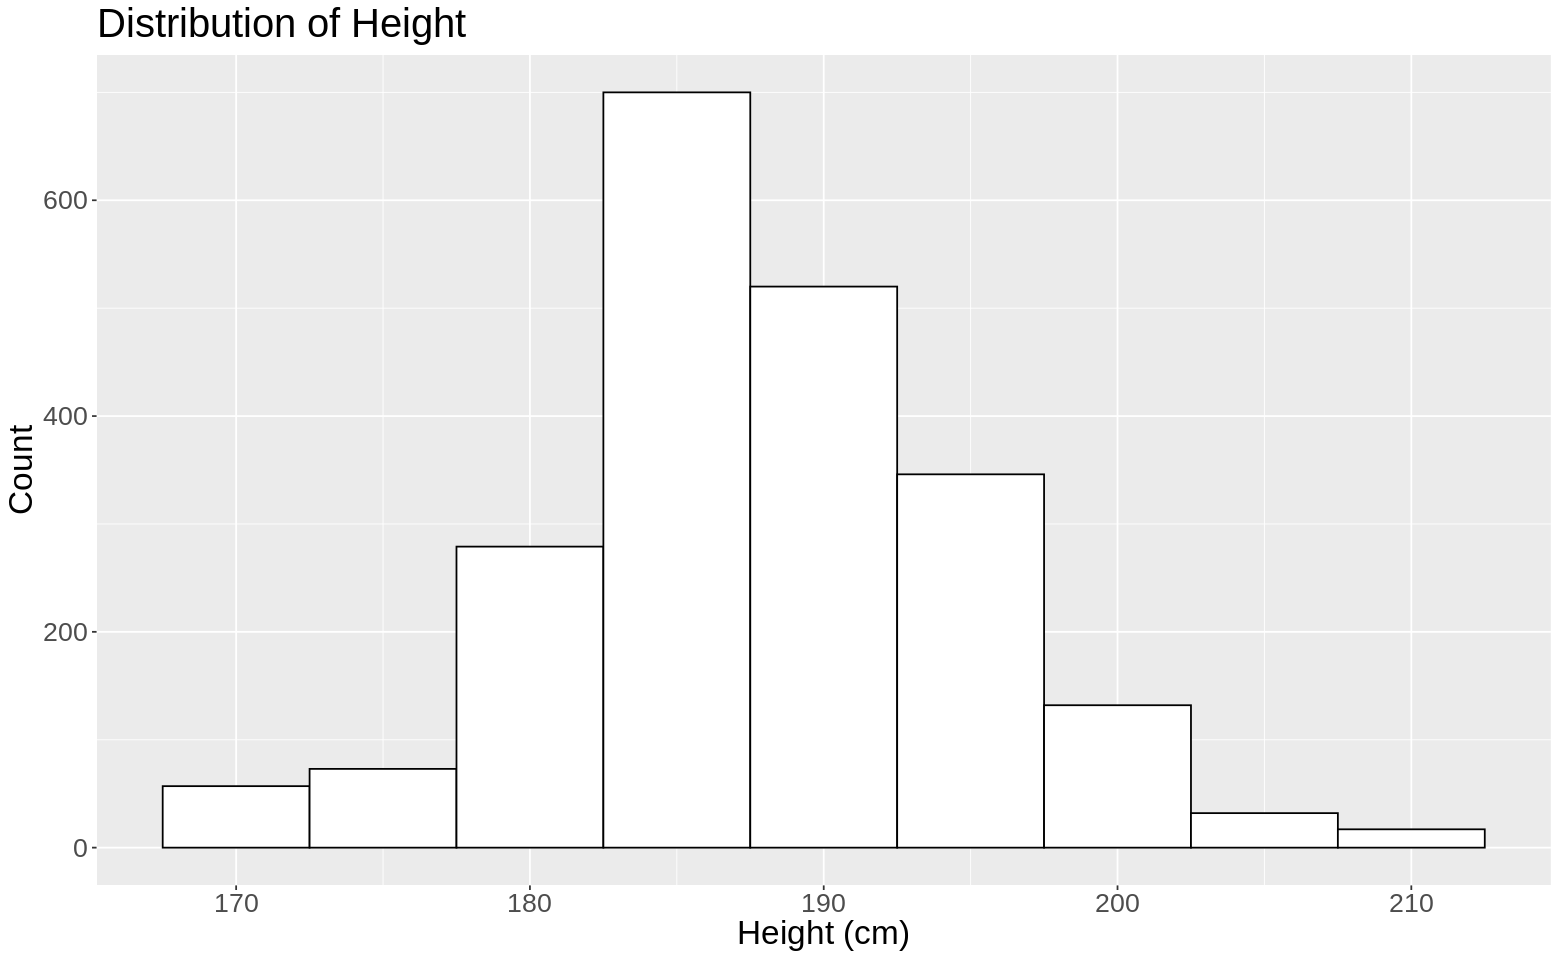

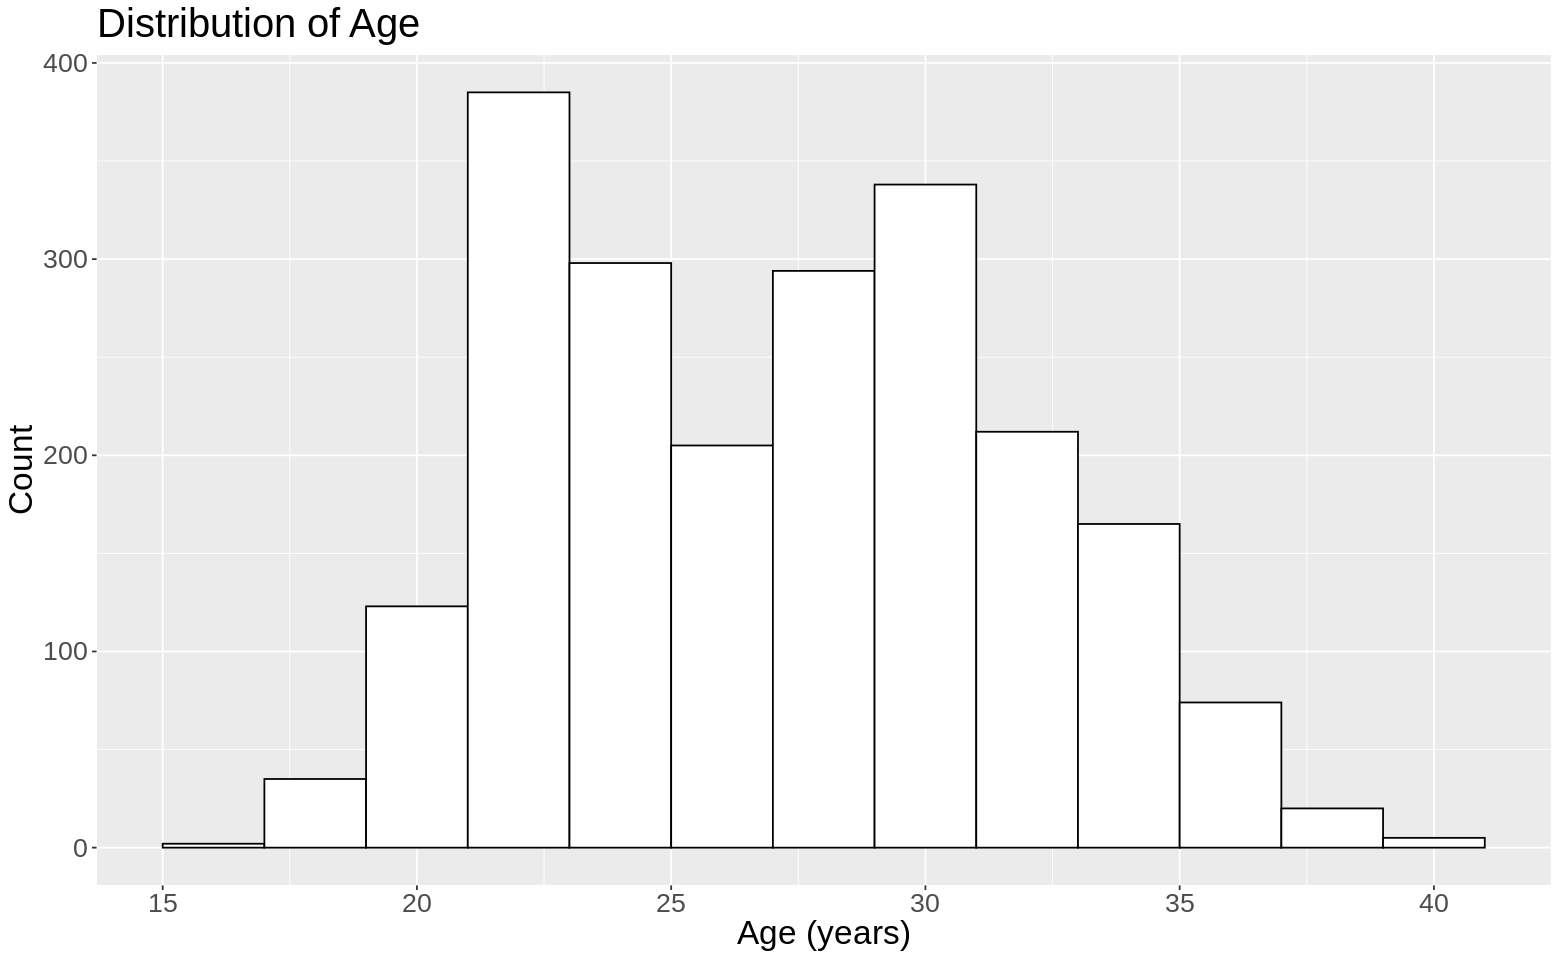

In [7]:
#Histograms of the height and age variable distributions ONLY USING TRAINING DATA
options(repr.plot.width = 13, repr.plot.height =8)
prelim_hist_height <- ggplot(data = match_train, aes(x = ht))+
                geom_histogram(binwidth = 5, color = "black", fill = "white")+
                labs(x = "Height (cm)", y = "Count")+
                ggtitle("Distribution of Height")+
                theme(text = element_text(size = 20))

prelim_hist_height # Figure1.1

prelim_hist_age <- ggplot(data = match_train, aes(x = age))+
                geom_histogram(binwidth = 2, color = "black", fill = "white")+
                labs(x = "Age (years)", y = "Count")+
                ggtitle("Distribution of Age")+
                theme(text = element_text(size = 20))
prelim_hist_age # Figure1.2

In [8]:
#to check the percentage of winning and losing in the data set to make sure one don't outweight the other
match_proportions <- match_train |>
                      group_by(match_result) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(match_train))

match_proportions #table 1.4

match_result,n,percent
<chr>,<int>,<dbl>
lose,1068,49.53618
win,1088,50.46382


In [9]:
#Change datatype of match_result from character to factor in order for the next few functions to work
match_train$match_result <- as.factor(match_train$match_result)
match_test$match_result <- as.factor(match_test$match_result)

In [10]:
#setup standard recipe, setup knn_spec to tune for k

match_recipe <- recipe(match_result ~ ht + age, data = match_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [11]:
#try 10 different k values, every 3 from 1 to 30
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 3))

match_vfold <- vfold_cv(match_train, v = 5, strata = match_result)

knn_results <- workflow() |>
  add_recipe(match_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = match_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies #table 1.5

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4949009,5,0.007389835,Preprocessor1_Model01
4,accuracy,binary,0.4902606,5,0.007407483,Preprocessor1_Model02
7,accuracy,binary,0.5296942,5,0.009239175,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
22,accuracy,binary,0.5246102,5,0.008742071,Preprocessor1_Model08
25,accuracy,binary,0.5097610,5,0.007144487,Preprocessor1_Model09
28,accuracy,binary,0.5097545,5,0.005610510,Preprocessor1_Model10


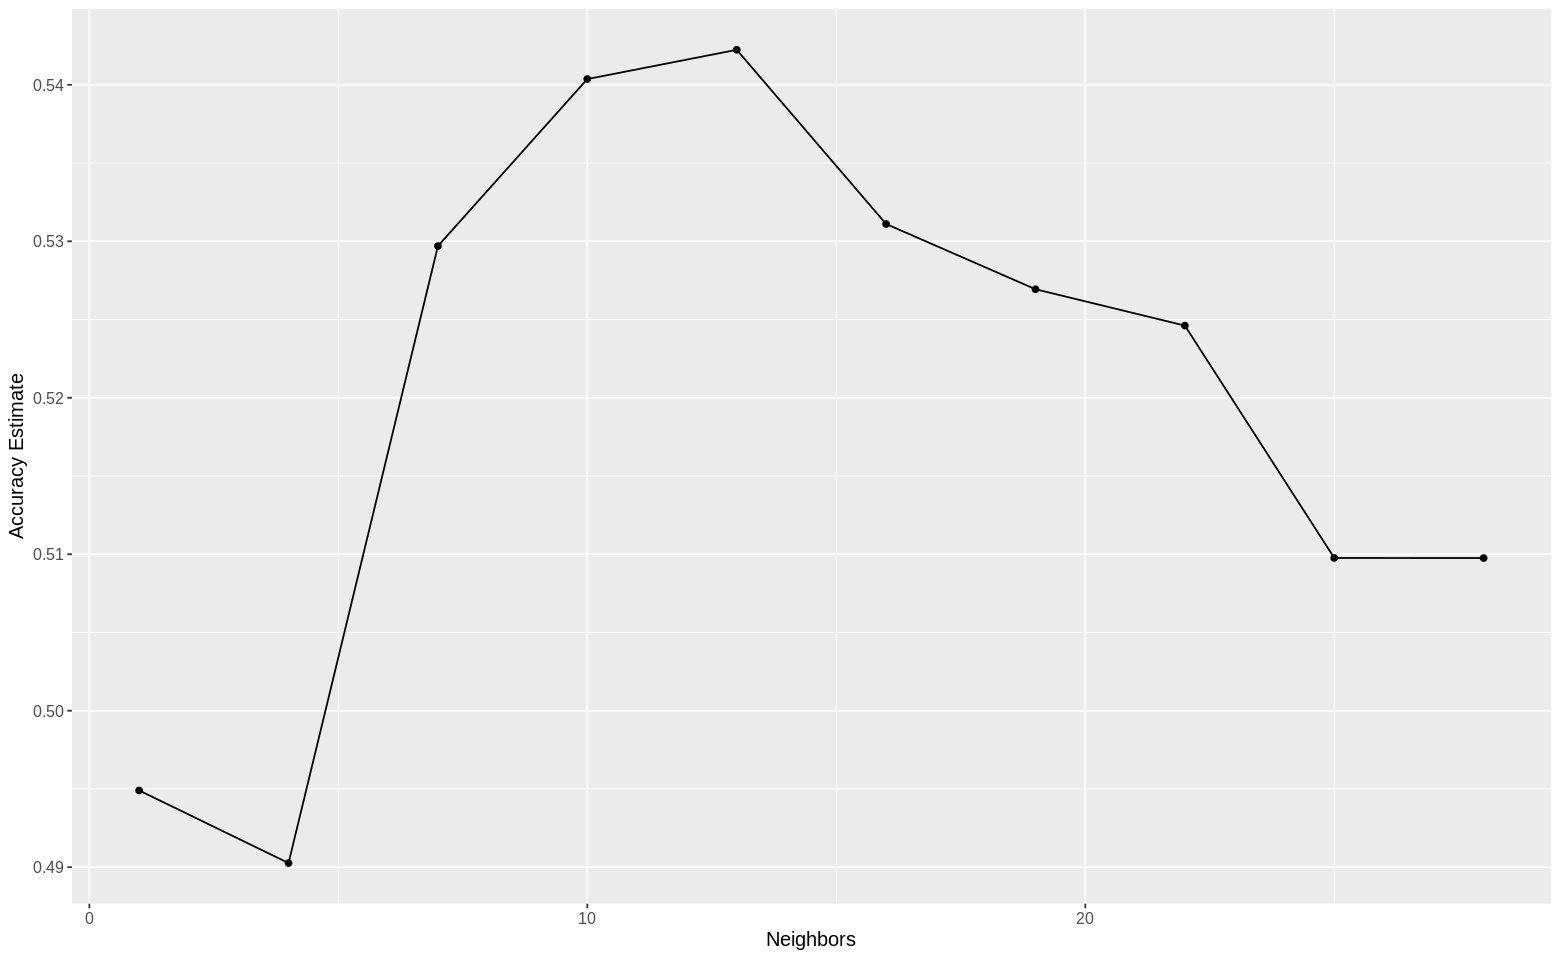

In [12]:
#plotting accuracies of different k, best seems to be 13
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k # Figure1.3

In [13]:
#display accuracy of model using best k and cross-validation 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(match_recipe) |>
  add_model(knn_spec) |>
  fit_resamples(resamples = match_vfold)

knn_fit |> 
  collect_metrics() 

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.5422373,5,0.008441603,Preprocessor1_Model1
roc_auc,binary,0.5570012,5,0.008990000,Preprocessor1_Model1


In [14]:
#test predictions using test-data
knn_fit <- workflow() |>
  add_recipe(match_recipe) |>
  add_model(knn_spec) |>
  fit(match_train)

match_test_predictions <- predict(knn_fit, match_test) |>
  bind_cols(match_test)

match_test_predictions |>
  metrics(truth = match_result, estimate = .pred_class) |>
  filter(.metric == "accuracy")

confusion <- match_test_predictions |>
             conf_mat(truth = match_result, estimate = .pred_class)

match_test_predictions
confusion #this is our confusion matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5312067


.pred_class,ht,age,match_result
<fct>,<int>,<dbl>,<fct>
win,183,31.7,win
win,180,29.0,win
win,188,32.6,win
⋮,⋮,⋮,⋮
win,181,31.2,lose
lose,185,27.8,lose
lose,188,32.7,lose


          Truth
Prediction lose win
      lose  207 187
      win   151 176

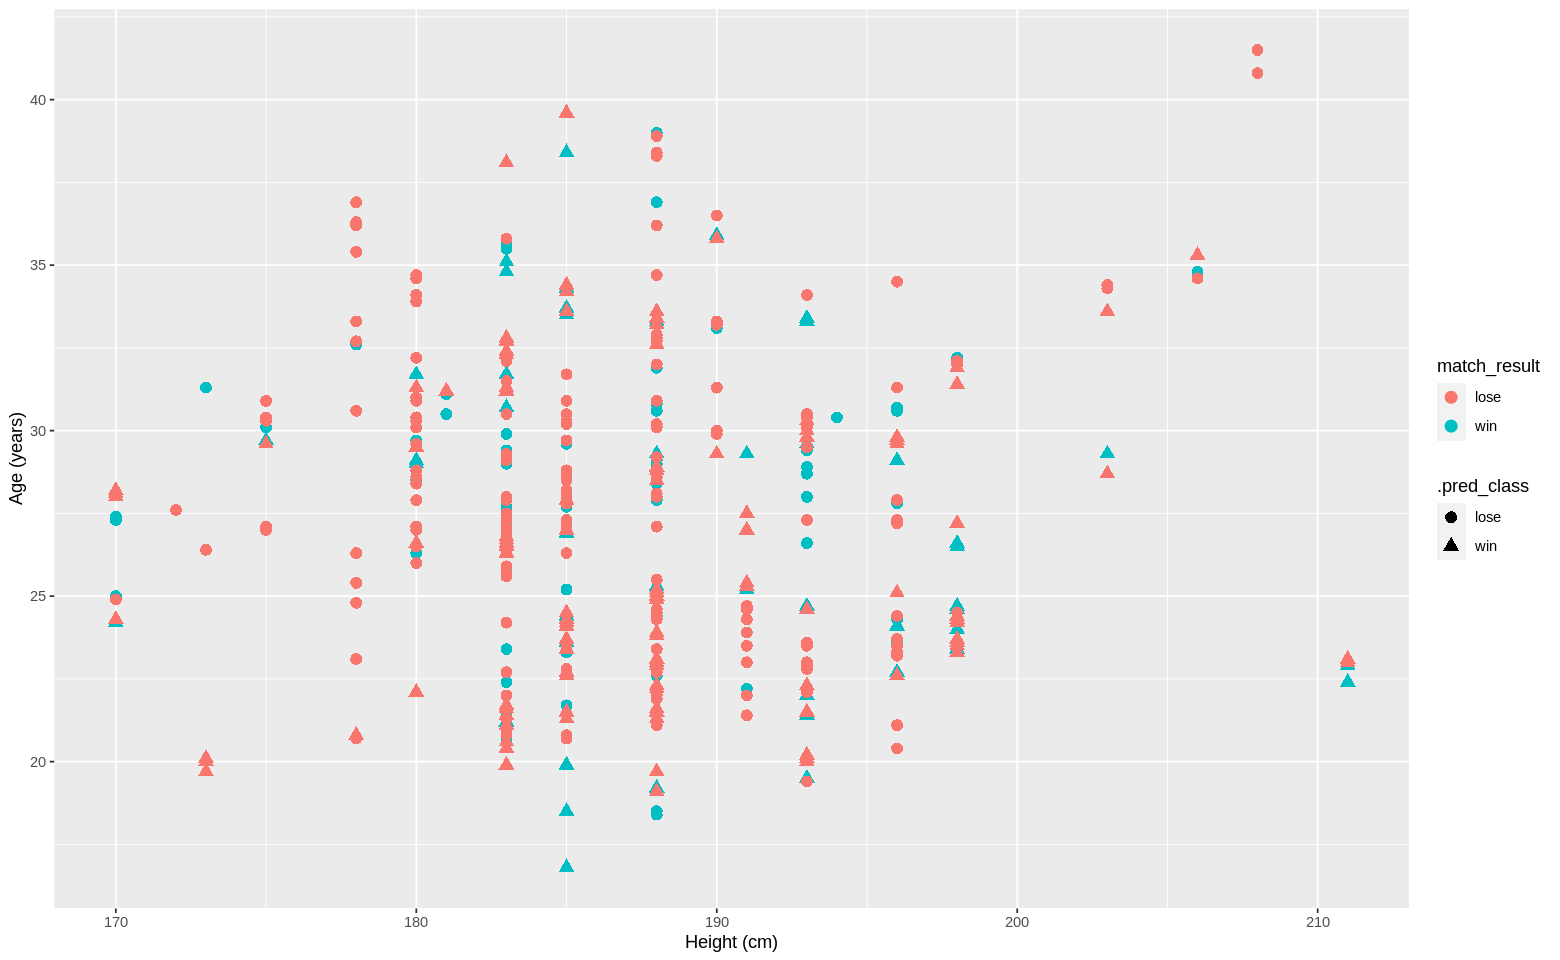

In [15]:
#graph plotting predictions v real values, still needs formatting 
prediction_plot <- ggplot(data = match_test_predictions,aes(x= ht, y=age, color = match_result, shape = .pred_class))+
                        geom_point(size = 3) + labs(x = "Height (cm)", y = "Age (years)")
prediction_plot

.pred_class,ht,age,match_result,predict_accuracy
<fct>,<int>,<dbl>,<fct>,<lgl>
win,183,31.7,win,TRUE
win,180,29.0,win,TRUE
win,188,32.6,win,TRUE
⋮,⋮,⋮,⋮,⋮
win,181,31.2,lose,FALSE
lose,185,27.8,lose,TRUE
lose,188,32.7,lose,TRUE


.pred_class,match_result,n,predict_accuracy
<fct>,<fct>,<int>,<lgl>
lose,lose,207,TRUE
lose,win,187,FALSE
win,lose,151,FALSE
win,win,176,TRUE


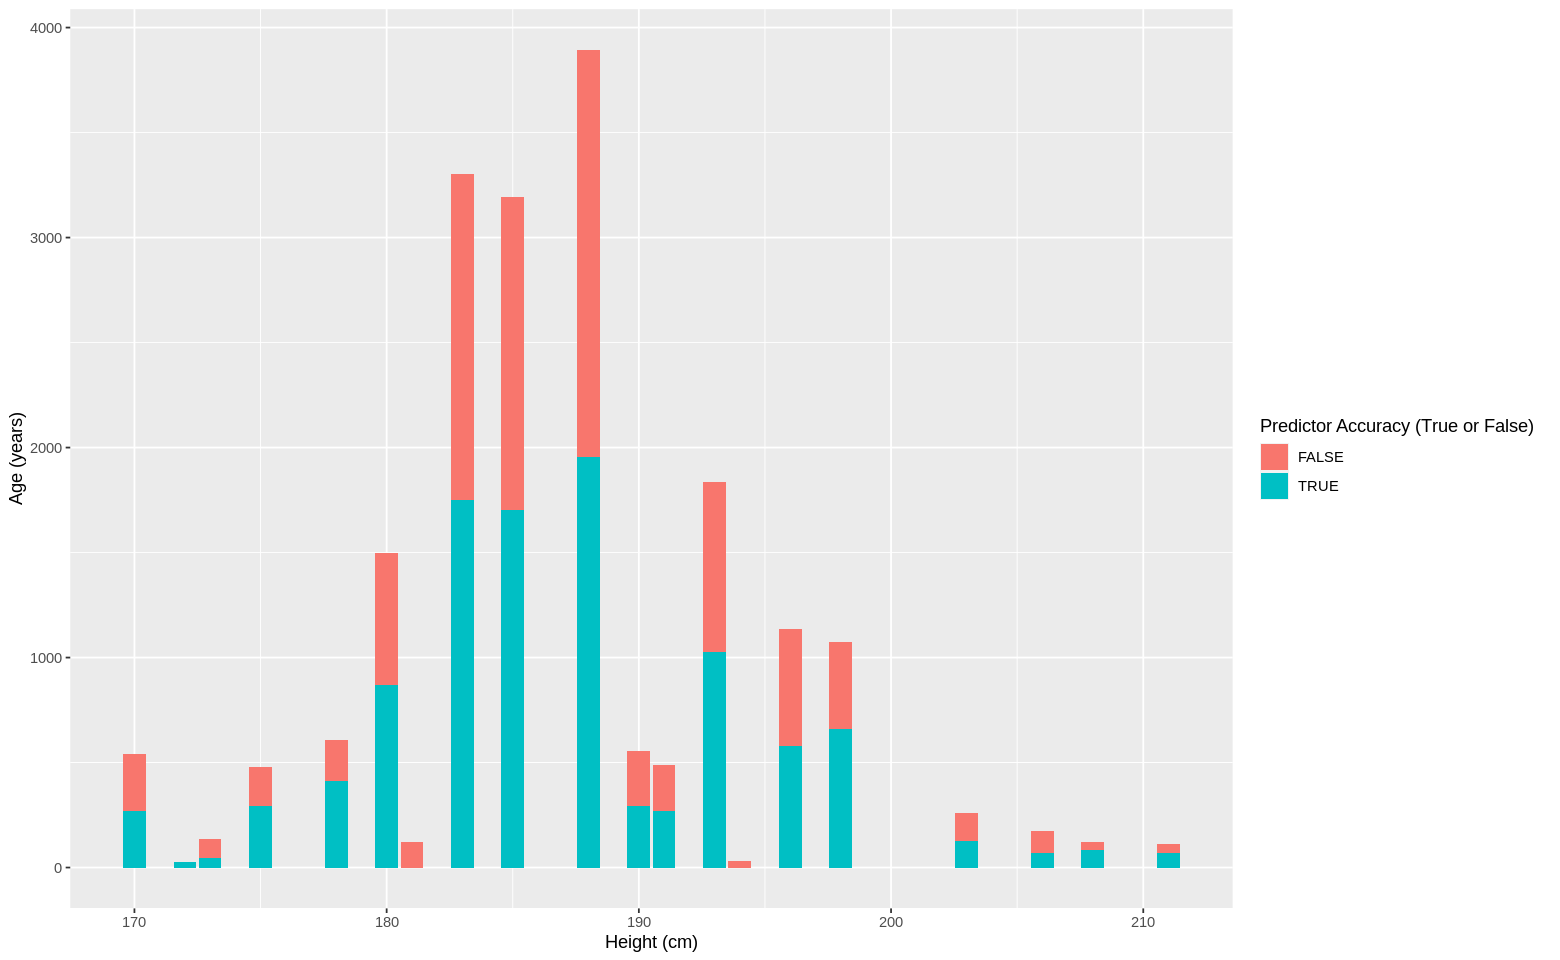

.pred_class,n
<fct>,<int>
lose,394
win,327


match_result,n
<fct>,<int>
lose,358
win,363


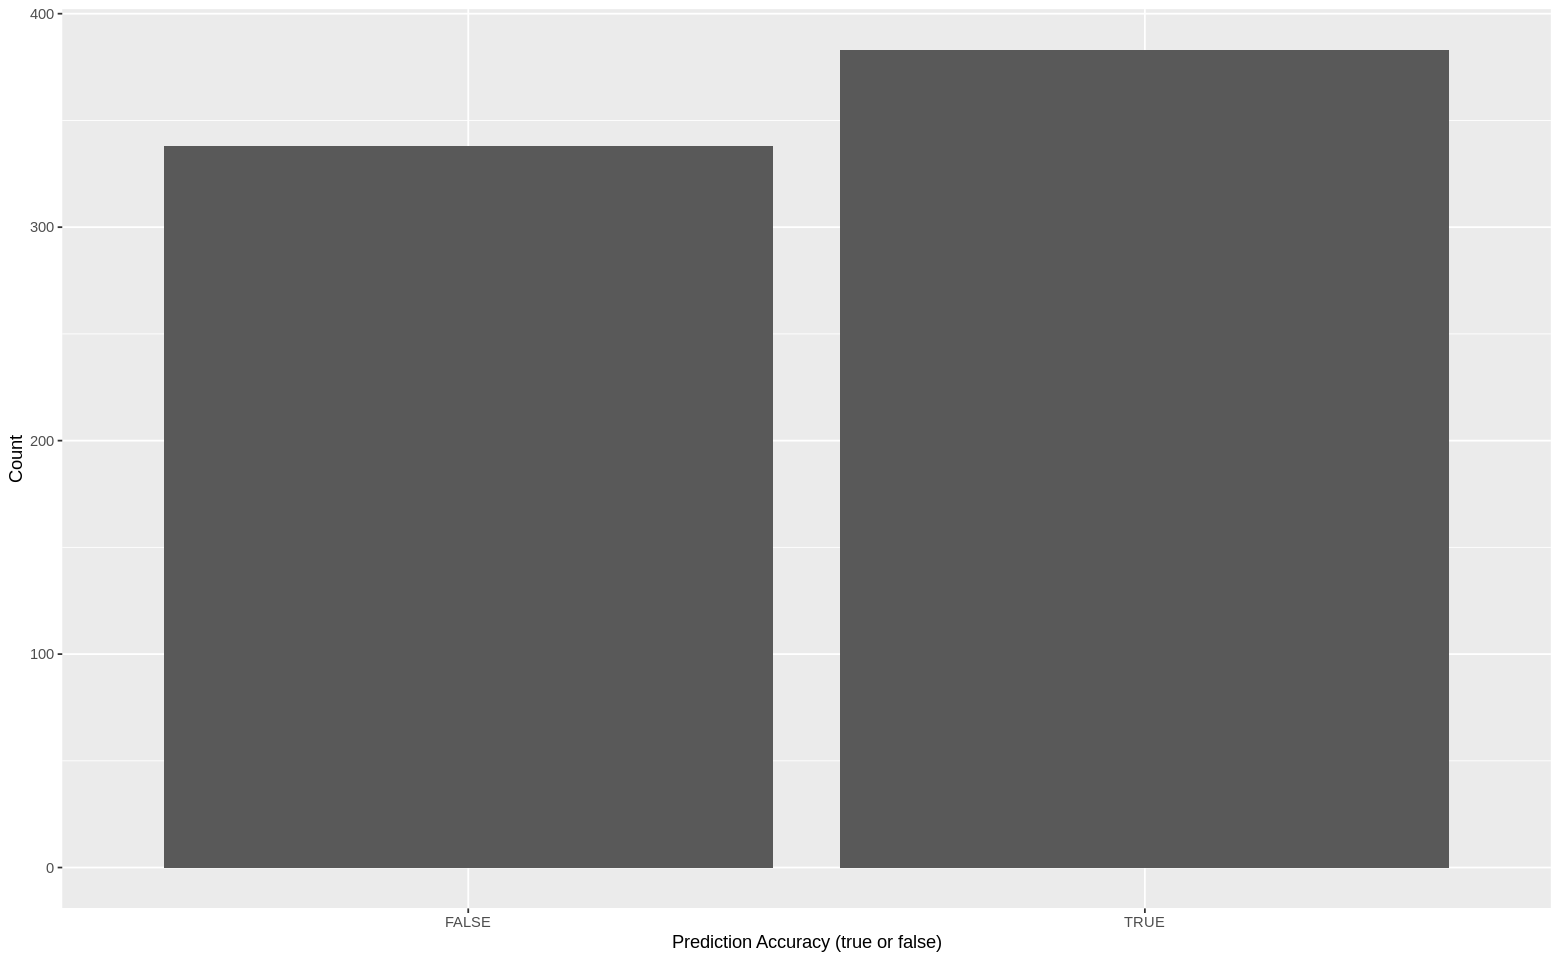

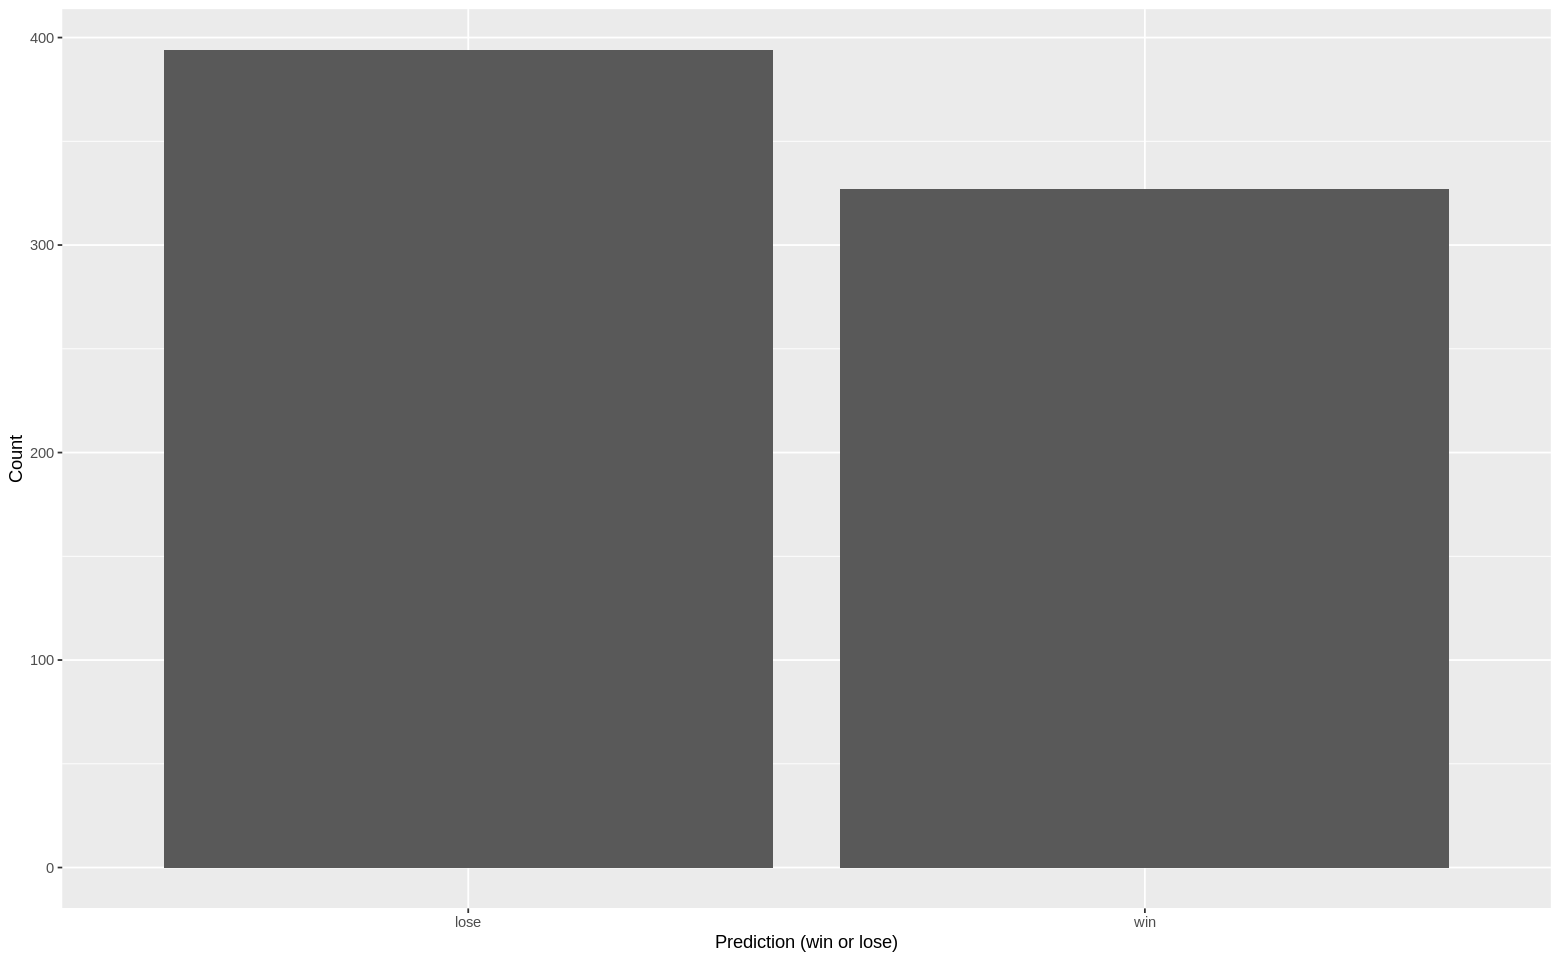

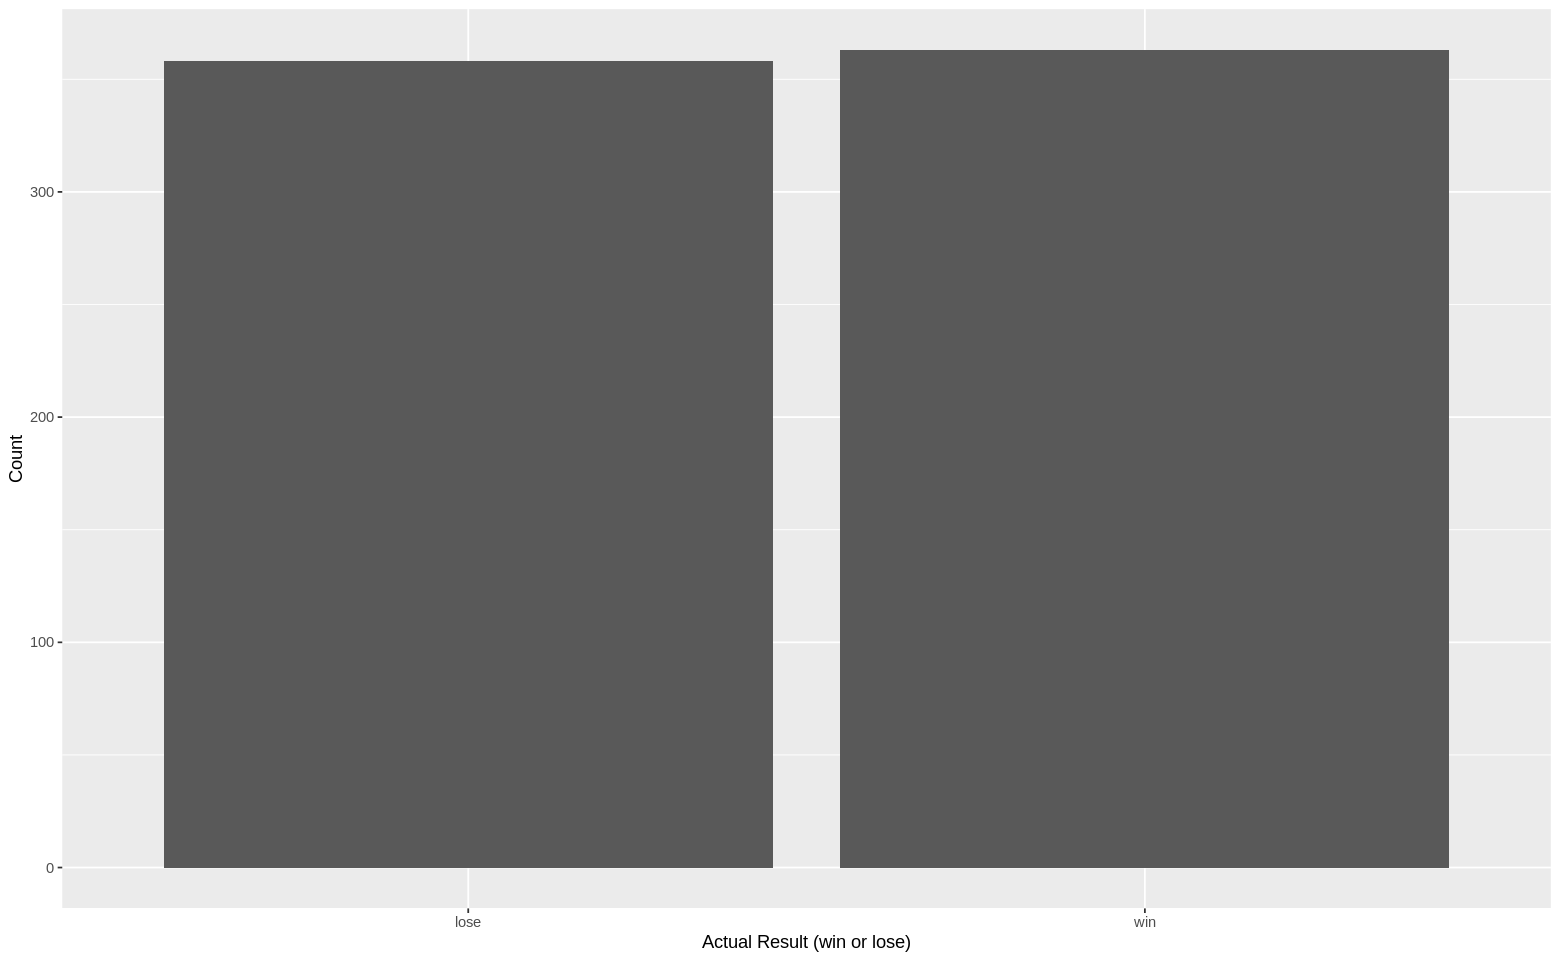

In [29]:
#creating a new column to determine how accurate our predictions are
prediction_accuracy <- match_test_predictions |>
    mutate(predict_accuracy = .pred_class == match_result)
prediction_accuracy

prediction_accuracy_plot <- ggplot(data = prediction_accuracy,aes(x= ht, y=age, fill = predict_accuracy)) +
                        geom_bar(stat = "identity") + labs(x = "Height (cm)", y = "Age (years)", fill = "Predictor Accuracy (True or False)")
prediction_accuracy_plot

predict_accurate <- prediction_accuracy |> 
    count(.pred_class, match_result) |>
    mutate(predict_accuracy = .pred_class == match_result)
    #pivot_wider(names_from = predict_accuracy, values_from = n)
predict_accurate
predict_accurate_plot <- ggplot(predict_accurate, aes(x= predict_accuracy, y=n)) +
                        geom_bar(stat = "identity") + labs(x = "Prediction Accuracy (true or false)", y = "Count")
predict_accurate_plot

pred_class_data <- prediction_accuracy |>
    count(.pred_class)
pred_class_data

match_result_data <- prediction_accuracy |>
    count(match_result)
match_result_data

pred_class_plot <- ggplot(pred_class_data, aes(x= .pred_class, y= n)) +
                        geom_bar(stat = "identity") + labs(x = "Prediction (win or lose)", y = "Count")

match_result_plot <- ggplot(match_result_data, aes(x= match_result, y= n)) +
                        geom_bar(stat = "identity") + labs(x = "Actual Result (win or lose)", y = "Count")
pred_class_plot
match_result_plot

# Method

We create a new observation and try to predict the class for the new observation by three ways. The first way is to visualize the data and to see where the point fit and classified as. The second way is to create a tibble for the new observation. Then we use the predict function and the model to predict the new observation's class type. The third way is to use the squared distance formula to pick out 13 nearest points as references to classify the new observation.


Warning message:
“Removed 47 rows containing missing values (geom_point).”


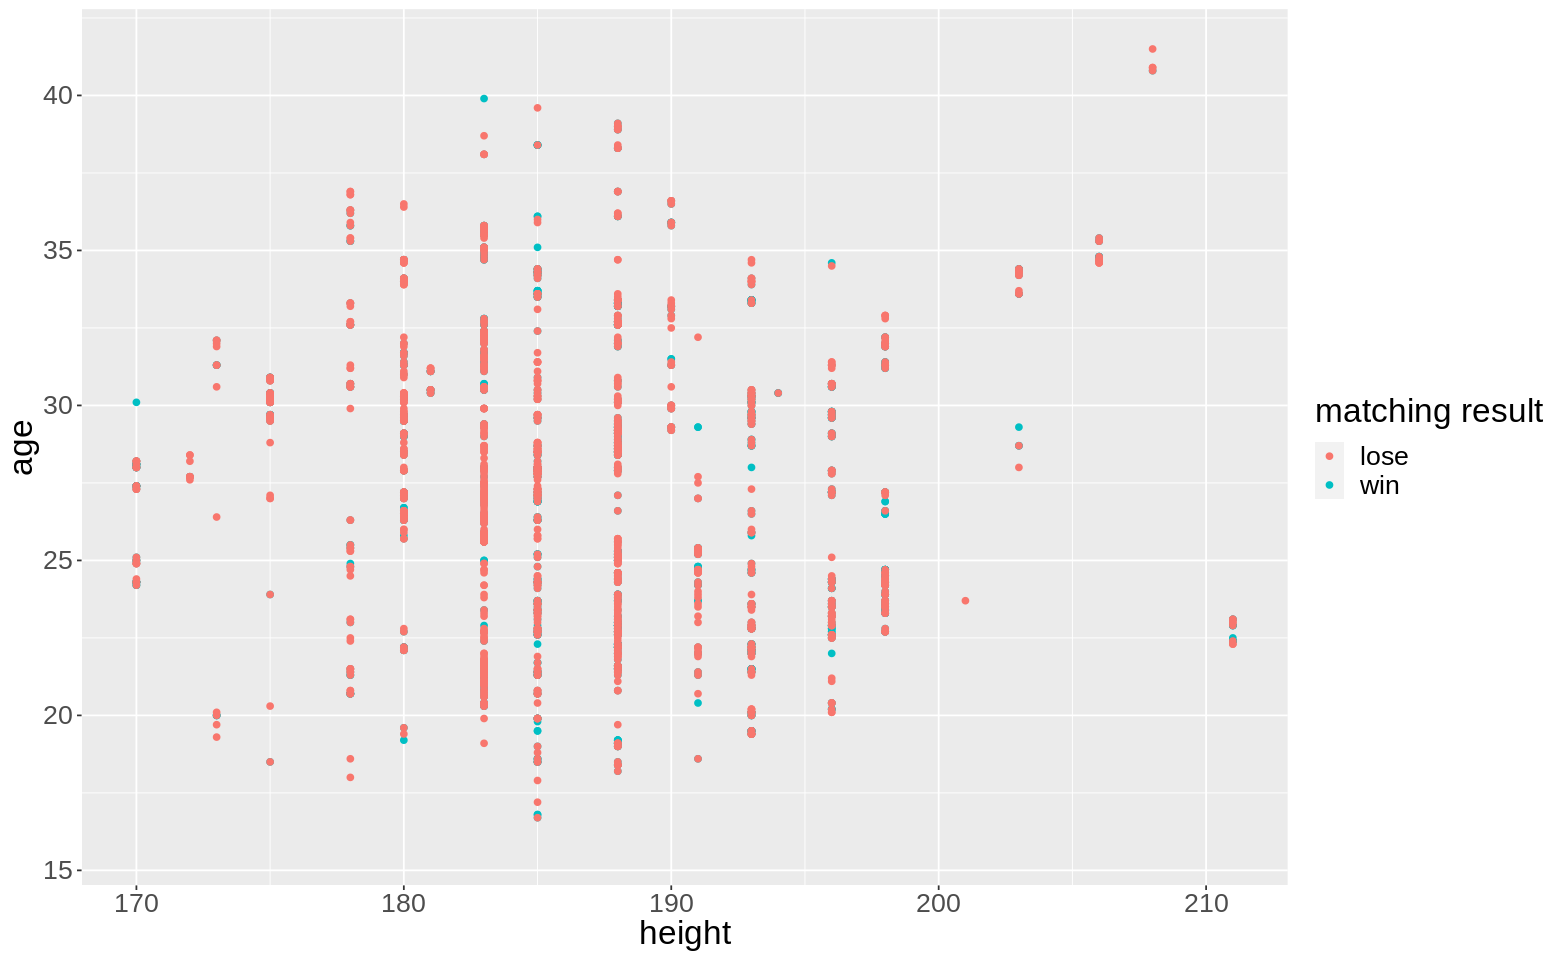

In [17]:
#method 1
point1 <- c(180,30)

ht_vs_age <- match_data_tidy |>
    ggplot(aes(x = ht, 
               y = age, 
               colour = match_result)) +
        labs(x = "height",
             y = "age",
            colour = 'matching result') +
        geom_point() + theme(text = element_text(size = 20))
        
ht_vs_age

In [18]:
#method 2
new_obs <- tibble(ht = 180, age = 30)

obs_prediction <- predict(knn_fit, new_obs)

obs_prediction

.pred_class
<fct>
lose


In [19]:
#method 3
new_obs_ht <- 180
new_obs_age <- 30

ht_age <- match_data_tidy |> mutate(dist_from_new_obs = sqrt((ht - new_obs_ht)^2 + 
                                                             (age - new_obs_age)^2)) |>
arrange(dist_from_new_obs) |> head(13)

ht_age

,ht,age,match_result,dist_from_new_obs
,<int>,<dbl>,<chr>,<dbl>
1,180,30.1,lose,0.1
2,180,30.1,lose,0.1
3,180,30.1,lose,0.1
⋮,⋮,⋮,⋮,⋮
11,180,30.2,lose,0.2
12,180,29.8,lose,0.2
13,180,30.2,lose,0.2


## Discussion:

        #summarize what you found
        #discuss whether this is what you expected to find?
        #discuss what impact could such findings have?
        #discuss what future questions could this lead to?

**What we found**

Our $k$-nearest neighbours algorithm allowed us to predict the value of a categorical variable (the win/loss of a match) by basing our predictive algorithm on two quantitative variables (height and age of a tennis player in the ATP open). 

For this analysis, we chose a $k$-nearest neighbours ($k$-nn) algorithm to predict the result of a new potential value to classify. $K$-nn algorithms have an advantage to other machine-learning algorithms, according to Moldagulova and Sulaiman (2017) because of tbeir ease of interpretation. Timbers _et al._ (2022) also suggest that the $k$-nn algorithm is also simple and intuitive.

In our $k$-nn classification algorithm, we followed all the standard procedures as outlined by Timbers _et al._ (2022). First, we tidied the dataset and then split it into 'training' and 'testing' segments. We first built the model using the training segment of 75% of the original dataset. The testing dataset helps us later to evaluate the model on data it has not seen before (therefore 25% of the original dataset).

Subsequently, we tuned the classifier (by selecting the number of $k$s in the $k$-nn algorithm) through maximising its estimated accuracy by cross-validating. We chose k = 13 after cross-validation because it maximised estimated accuracy (_see Figure 1.3_)

In our analysis, we found that the age and height of tennis players had little impact on the end result of matches. The algorithm  predicted a loss 207 times where it should have been a loss but 187 times when it should have been a win according to our testing dataset (_see the confusion matrix_). In fact, the impact of height and age only explained 53.12% of wins in the dataset—essentially only marginally better than pure chance. 

**What we expected to find**

Our expected outcomes differed significantly from our findings. As written in our proposal, we expected our selected physical characteristics to have a key role in determining the outcome of the end result of a tennis match. For height, we believed that the taller players will be more likely to win because their height will translate to longer arms and legs; this would give them a greater advantage than those who are shorter. For age, we expected that older players will be less likely to win because older players are more liable to injuries and health conditions, impacting their athletic abilities. Overall, we expected individuals who are tall and of a younger age to be the ideal players to win more matches. However, our results showed that age and height have little effect on matches' outcomes—the end accuracy of our model was only 53.12%. 

**What impact strong findings would have had and what future research can be done**

Studies in other sports suggest that physical characteristics *do* have a significant effect on outcomes (Davis _et al._, 2003), but it is likely that our analysis was too shallow in its scope, using only two predictor variables. 

Strong findings in our analysis could have had an impact on the future of ATP tournaments, revealing the uncontrollable advantages certain players have over others. This could lead to further research what else may be unfairly impacting players’ tennis playing capabilities: mental health history, social background, or other physical and circumstantial characteristics.

We may be able to look further into how severely such differences have on the likelihood of certain players winning or losing based on statistical analysis alone.


## References:

Moldagulova, A. & Sulaiman, R. B. (2017) Using KNN algorithm for classification of textual documents.  2017 8th International Conference on Information Technology (ICIT), 17-18 May 2017. pp. 665-671.

Timbers, T., Campbell, T., & Lee M. (2022) "Data Science: A First Introduction": available online. https://datasciencebook.ca/index.html


Davis, D. S., Briscoe, D. A., Markowski, C. T., Saville, S. E. & Taylor, C. J. (2003). Physical characteristics that predict vertical jump performance in recreational male athletes, Physical Therapy in Sport, vol. 4, no. 4, pp. 167-174


